In [2]:
import numpy as np
import pandas as pd
import pickle
import tensorflow as tf
from tensorflow import keras
from keras import backend as K
from keras import metrics
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder, StandardScaler, MinMaxScaler
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score
from google.colab import drive
import matplotlib.pyplot as plt
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Reshape, Flatten, Input, Concatenate, Embedding

from keras.layers import Input, Dense, Reshape, Flatten, Dropout, multiply, concatenate
from keras.layers import BatchNormalization, Activation, Embedding, ZeroPadding2D
#from keras.layers.advanced_activations import LeakyReLU
from keras.models import Sequential, Model
from keras.optimizers import Adam


drive.mount('/content/drive')

Mounted at /content/drive


In [3]:
# Load the UNSW training dataset
train_data = pd.read_csv("/content/drive/MyDrive/UNI/CMP6200_FYP/NIDS_Datasets/UNSW/UNSW_NB15_training-set.csv")

# Load the UNSW testing dataset
test_data = pd.read_csv("/content/drive/MyDrive/UNI/CMP6200_FYP/NIDS_Datasets/UNSW/UNSW_NB15_testing-set.csv")

# Concatenate training and testing data
data = pd.concat([train_data, test_data])

# Drop columns that are not required for training
X = data.drop(['id', 'attack_cat', 'label'], axis=1)

# Encode categorical features
cat_features = ['proto', 'service', 'state']
for feature in cat_features:
    encoder = LabelEncoder()
    encoder.fit(X[feature])
    X[feature] = encoder.transform(X[feature])

# Normalize numeric features
num_features = ['dur', 'spkts', 'dpkts', 'sbytes', 'dbytes', 'rate', 'sttl', 'dttl', 'sload', 'dload', 'sloss',
                'dloss', 'sinpkt', 'dinpkt', 'sjit', 'djit', 'swin', 'stcpb', 'dtcpb', 'dwin', 'tcprtt', 'synack',
                'ackdat', 'smean', 'dmean', 'trans_depth', 'response_body_len', 'ct_srv_src', 'ct_state_ttl',
                'ct_dst_ltm', 'ct_src_dport_ltm', 'ct_dst_sport_ltm', 'ct_dst_src_ltm', 'ct_ftp_cmd', 'ct_flw_http_mthd',
                'ct_src_ltm', 'ct_srv_dst']

scaler = MinMaxScaler()
X[num_features] = scaler.fit_transform(X[num_features])

# Split into training, validation and testing data
train_X, val_X, train_y, val_y = train_test_split(X[:len(train_data)], train_data['label'], test_size=0.2, random_state=42)
test_X = X[len(train_data):]
test_y = test_data['label']

# Convert to numpy arrays
X_train = train_X.values
X_val = val_X.values
X_test = test_X.values
y_train = train_y.values
y_val = val_y.values
y_test = test_y.values


In [4]:
print(X_train.shape)

(65865, 42)


In [5]:
print(y_train.shape)

(65865,)


In [6]:
from keras.models import Model
from keras.layers import Input, Dense, LeakyReLU
from keras.optimizers import Adam
import numpy as np

def build_generator(latent_dim, n_classes):
    # input layer for the latent noise vector
    noise = Input(shape=(latent_dim,))
    # input layer for the class label
    label = Input(shape=(n_classes,))
    # concatenate the noise and label inputs
    x = Concatenate()([noise, label])
    # hidden layer
    x = Dense(256)(x)
    x = LeakyReLU(alpha=0.2)(x)
    # output layer with tanh activation
    out_layer = Dense(42, activation='tanh')(x)
    # define the generator model
    generator = Model([noise, label], out_layer)
    return generator


def build_discriminator(in_shape=(42,), n_classes=10):
    # input layer for the image data
    img = Input(shape=in_shape)
    # input layer for the class label
    label = Input(shape=(n_classes,))
    # concatenate the image and label inputs
    x = Concatenate()([img, label])
    # hidden layer
    x = Dense(512)(x)
    x = LeakyReLU(alpha=0.2)(x)
    # output layer with sigmoid activation
    out_layer = Dense(1, activation='sigmoid')(x)
    # define the discriminator model
    discriminator = Model([img, label], out_layer)
    # compile the model with binary cross-entropy loss and Adam optimizer
    discriminator.compile(loss='binary_crossentropy', optimizer=Adam(learning_rate=0.0002, beta_1=0.5))
    return discriminator

def build_gan(generator, discriminator):
    # make sure the discriminator is not trainable when updating the generator via the GAN model
    discriminator.trainable = False
    # input layers for the GAN model (noise and class label)
    gan_noise = Input(shape=(latent_dim,))
    gan_label = Input(shape=(n_classes,))
    # use the generator to generate an image from the noise and class label inputs
    x = generator([gan_noise, gan_label])
    # use the discriminator to classify the generated image as real or fake
    gan_output = discriminator([x, gan_label])
    # define the GAN model
    gan = Model([gan_noise, gan_label], gan_output)
    # compile the GAN model with binary cross-entropy loss and Adam optimizer
    gan.compile(loss='binary_crossentropy', optimizer=Adam(learning_rate=0.0002, beta_1=0.5))
    return gan

# size of the latent noise vector (i.e. size of generator input)
latent_dim = 100

# number of classes in your dataset (i.e. size of conditional input)
n_classes = 10

# build the generator and discriminator models
generator = build_generator(latent_dim, n_classes)
discriminator = build_discriminator(n_classes=n_classes)

# build the GAN model using the generator and discriminator models
gan = build_gan(generator, discriminator)

# load your preprocessed training data here (make sure it's normalized between -1 and 1)
X_train = X_train
y_train_one_hot = keras.utils.to_categorical(y_train, num_classes=n_classes)

# number of epochs to train for
epochs = 20

# batch size for training
batch_size = 128

# calculate the number of batches per epoch
batches_per_epoch = int(X_train.shape[0] / batch_size)

# loop over epochs
for epoch in range(epochs):
  # loop over batches
  for batch in range(batches_per_epoch):
      # select a random batch of real images and their corresponding class labels
      idx = np.random.randint(0, X_train.shape[0], batch_size)
      real_imgs = X_train[idx]
      real_labels = y_train_one_hot[idx]

      # generate a batch of fake images using the generator
      noise = np.random.normal(0, 1, (batch_size, latent_dim))
      fake_labels = np.eye(n_classes)[np.random.choice(n_classes, batch_size)]
      fake_imgs = generator.predict([noise, fake_labels])

      # train the discriminator on the real and fake images
      d_loss_real = discriminator.train_on_batch([real_imgs, real_labels], np.ones((batch_size, 1)))
      d_loss_fake = discriminator.train_on_batch([fake_imgs, fake_labels], np.zeros((batch_size, 1)))
      d_loss = 0.5 * np.add(d_loss_real, d_loss_fake)

      # generate a batch of noise vectors and class labels for training the generator via the GAN model
      noise = np.random.normal(0, 1, (batch_size, latent_dim))
      sampled_labels = np.eye(n_classes)[np.random.choice(n_classes, batch_size)]

      # train the generator via the GAN model (i.e. update the generator weights to produce more realistic images)
      g_loss = gan.train_on_batch([noise, sampled_labels], np.ones((batch_size, 1)))

  # print the losses for this epoch
  print(f'Epoch: {epoch + 1}/{epochs} | D Loss: {d_loss:.4f} | G Loss: {g_loss:.4f}')

Streaming output truncated to the last 5000 lines.
4/4 [==============================] - 0s 5ms/step
Epoch: 11/20 | D Loss: 0.0001 | G Loss: 10.9407
4/4 [==============================] - 0s 2ms/step
Epoch: 12/20 | D Loss: 0.0000 | G Loss: 11.5697
4/4 [==============================] - 0s 5ms/step
Epoch: 13/20 | D Loss: 0.0000 | G Loss: 12.2343
4/4 [==============================] - 0s 4ms/step
Epoch: 14/20 | D Loss: 0.0000 | G Loss: 12.6397
4/4 [==============================] - 0s 3ms/step
Epoch: 15/20 | D Loss: 0.0000 | G Loss: 13.4934
4/4 [==============================] - 0s 4ms/step
Epoch: 16/20 | D Loss: 0.0000 | G Loss: 13.9915
4/4 [==============================] - 0s 8ms/step
Epoch: 17/20 | D Loss: 0.0000 | G Loss: 14.4019
4/4 [==============================] - 0s 3ms/step
Epoch: 18/20 | D Loss: 0.0000 | G Loss: 15.1376
4/4 [==============================] - 0s 5ms/step
Epoch: 19/20 | D Loss: 0.0000 | G Loss: 15.5762
4/4 [==============================] - 0s 5ms/step
Epoch: 

In [7]:
print(f'Epoch: {epoch + 1}/{epochs} | D Loss: {d_loss:.4f} | G Loss: {g_loss:.4f}')

Epoch: 20/20 | D Loss: 0.0000 | G Loss: 16.3576


In [13]:
# number of synthetic samples to generate
num_samples = 1000

# class label for the synthetic samples (e.g., label for a specific type of network attack)
sampled_label = 3

# generate noise vectors and class labels
noise = np.random.normal(0, 1, (num_samples, latent_dim))
sampled_labels = np.eye(n_classes)[np.full(num_samples, sampled_label)]

# generate synthetic samples using the generator model
generated_samples = generator.predict([noise, sampled_labels])

# combine the generated synthetic samples with your original training data
X_train_extended = np.concatenate([X_train, generated_samples], axis=0)
y_train_extended = np.concatenate([y_train, np.full(num_samples, sampled_label)], axis=0)
y_train_extended = keras.utils.to_categorical(y_train_extended, num_classes=n_classes)
print(y_train_extended.shape)
print(X_train_extended.shape)

32/32 [==============================] - 0s 1ms/step
(66865, 10)
(66865, 42)


In [15]:
#One hot encoding target variables
y_val = keras.utils.to_categorical(y_val, num_classes=n_classes)
y_test = keras.utils.to_categorical(y_test, num_classes=n_classes)

In [9]:
def precision(y_true, y_pred):
    true_positives = K.sum(K.round(K.clip(y_true * y_pred, 0, 1)))
    predicted_positives = K.sum(K.round(K.clip(y_pred, 0, 1)))
    precision = true_positives / (predicted_positives + K.epsilon())
    return precision

def recall(y_true, y_pred):
    true_positives = K.sum(K.round(K.clip(y_true * y_pred, 0, 1)))
    possible_positives = K.sum(K.round(K.clip(y_true, 0, 1)))
    recall = true_positives / (possible_positives + K.epsilon())
    return recall

def f1_score(y_true, y_pred):
    def recall(y_true, y_pred):
        true_positives = K.sum(K.round(K.clip(y_true * y_pred, 0, 1)))
        possible_positives = K.sum(K.round(K.clip(y_true, 0, 1)))
        recall = true_positives / (possible_positives + K.epsilon())
        return recall

    def precision(y_true, y_pred):
        true_positives = K.sum(K.round(K.clip(y_true * y_pred, 0, 1)))
        predicted_positives = K.sum(K.round(K.clip(y_pred, 0, 1)))
        precision = true_positives / (predicted_positives + K.epsilon())
        return precision

    precision = precision(y_true, y_pred)
    recall = recall(y_true, y_pred)
    return 2 * ((precision * recall) / (precision + recall + K.epsilon()))


2090/2090 [==============================] - 30s 12ms/step - loss: 0.3551 - accuracy: 0.8165 - precision: 0.8152 - recall: 0.8140 - f1_score: 0.8144 - val_loss: 0.2885 - val_accuracy: 0.8502 - val_precision: 0.8503 - val_recall: 0.8503 - val_f1_score: 0.8503


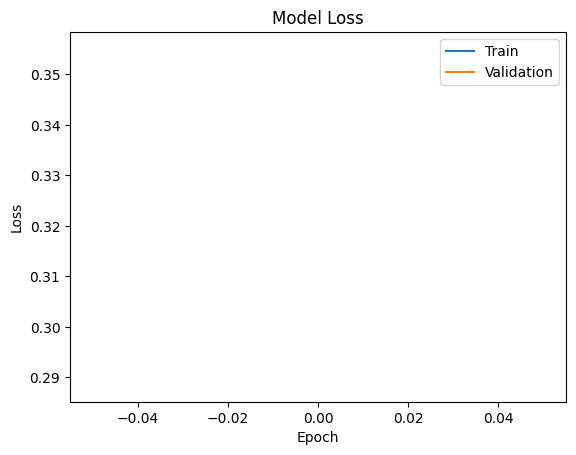

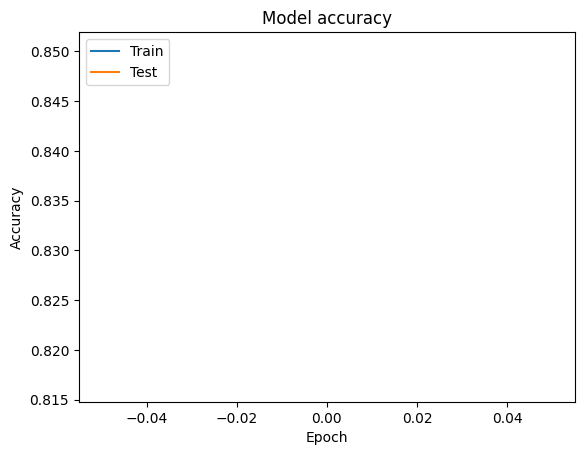

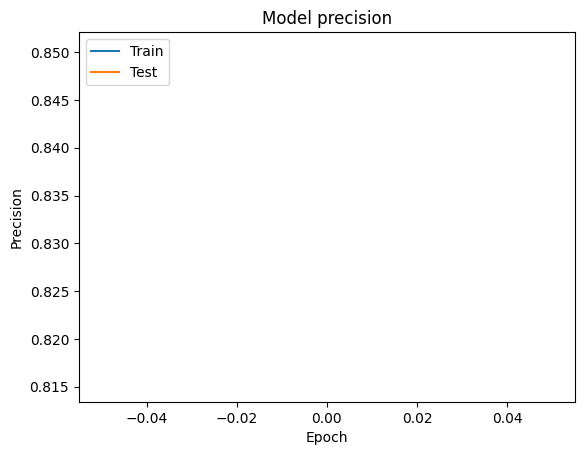

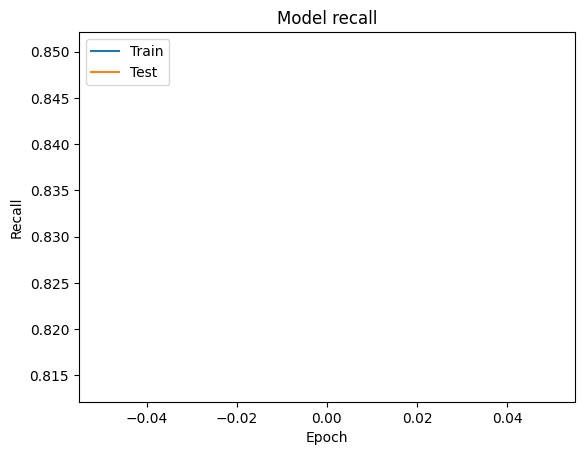

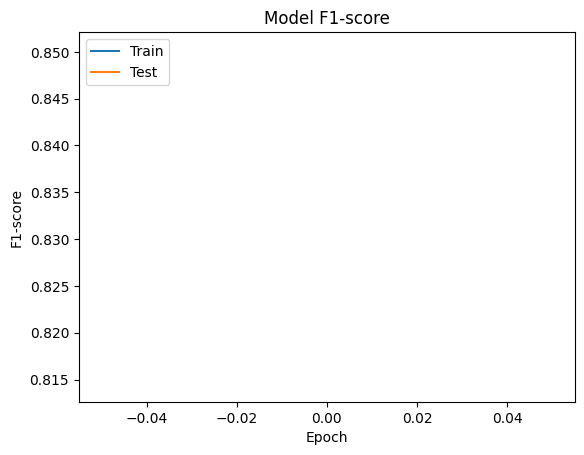

2090/2090 [==============================] - 22s 10ms/step - loss: 0.2781 - accuracy: 0.8539 - precision: 0.8539 - recall: 0.8539 - f1_score: 0.8539 - val_loss: 0.2616 - val_accuracy: 0.8588 - val_precision: 0.8588 - val_recall: 0.8587 - val_f1_score: 0.8588


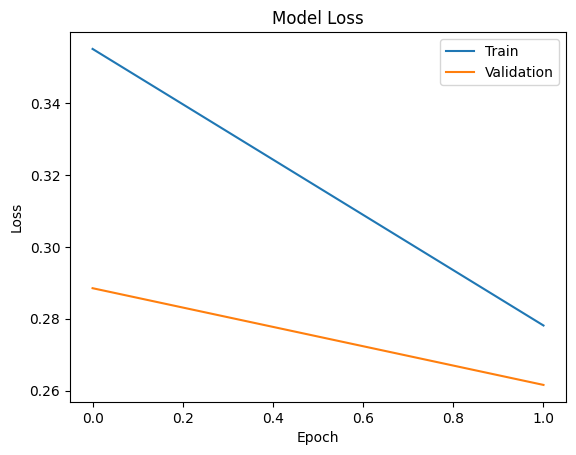

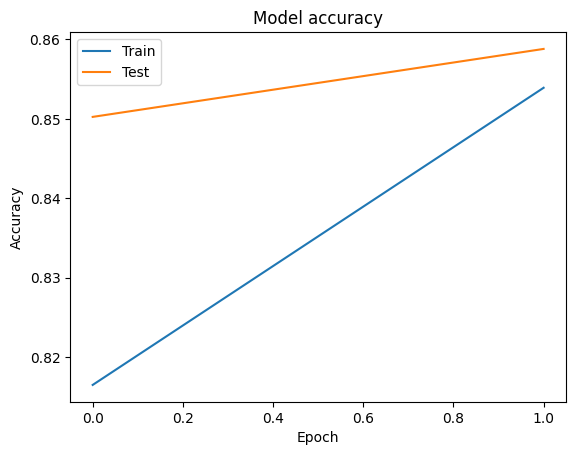

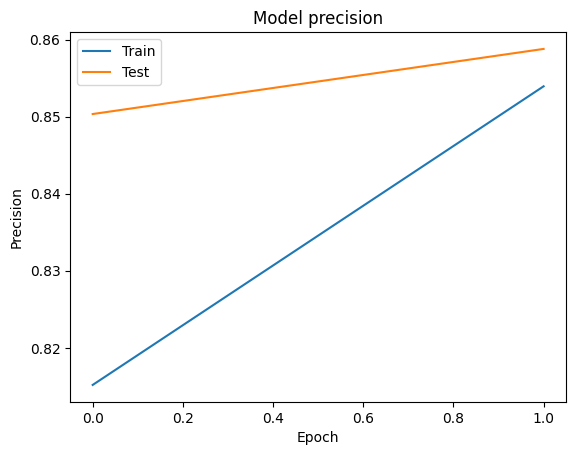

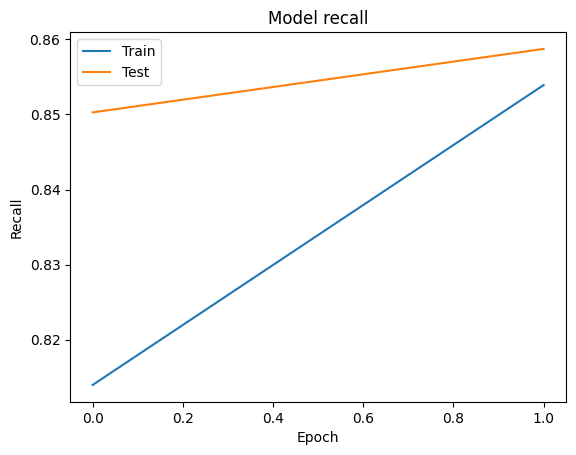

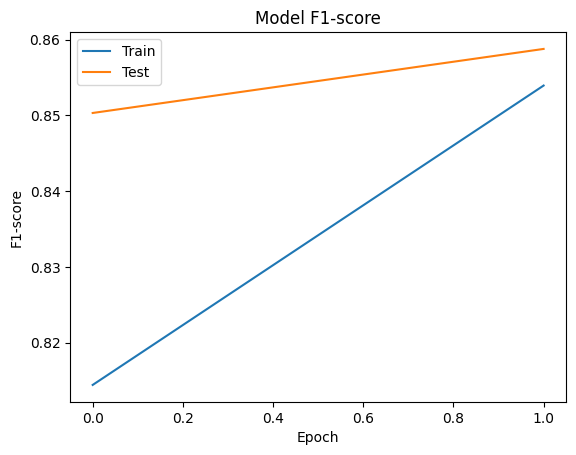

2090/2090 [==============================] - 20s 10ms/step - loss: 0.2574 - accuracy: 0.8661 - precision: 0.8661 - recall: 0.8661 - f1_score: 0.8661 - val_loss: 0.2462 - val_accuracy: 0.8775 - val_precision: 0.8775 - val_recall: 0.8775 - val_f1_score: 0.8775


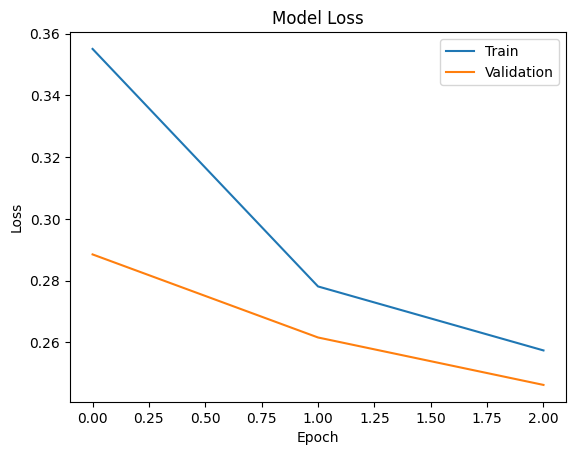

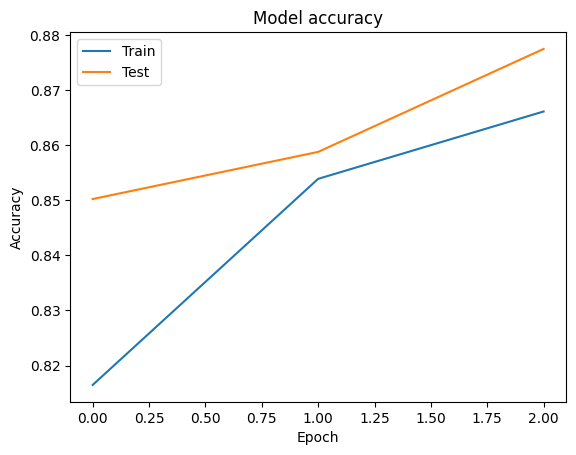

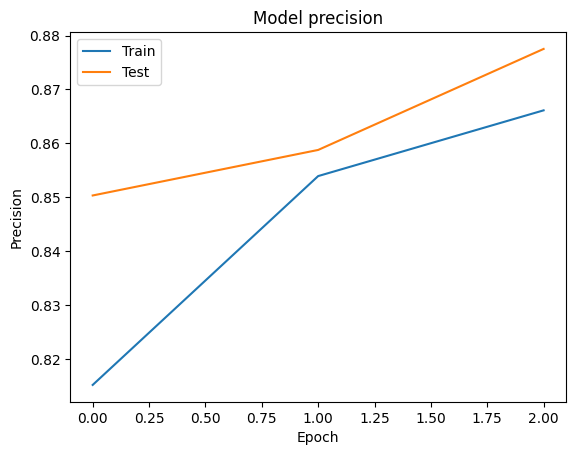

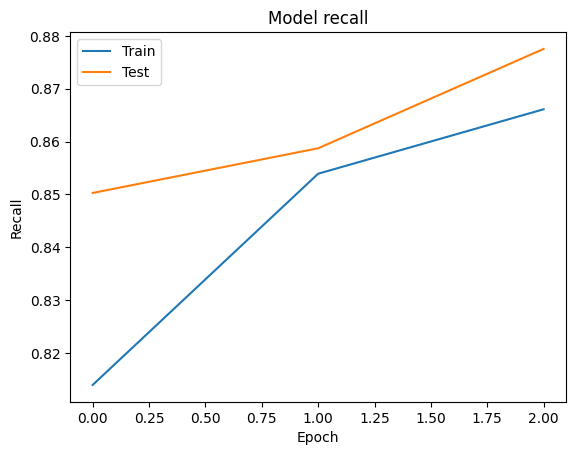

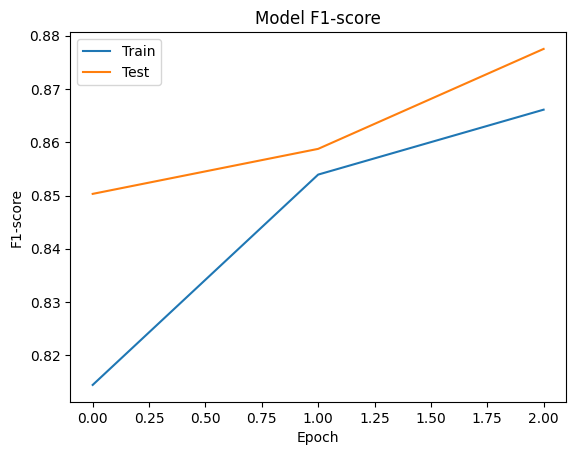

2090/2090 [==============================] - 21s 10ms/step - loss: 0.2319 - accuracy: 0.8797 - precision: 0.8797 - recall: 0.8797 - f1_score: 0.8797 - val_loss: 0.2200 - val_accuracy: 0.8914 - val_precision: 0.8914 - val_recall: 0.8914 - val_f1_score: 0.8914


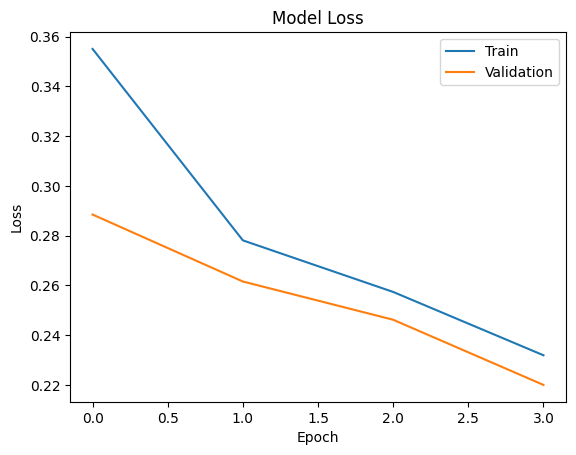

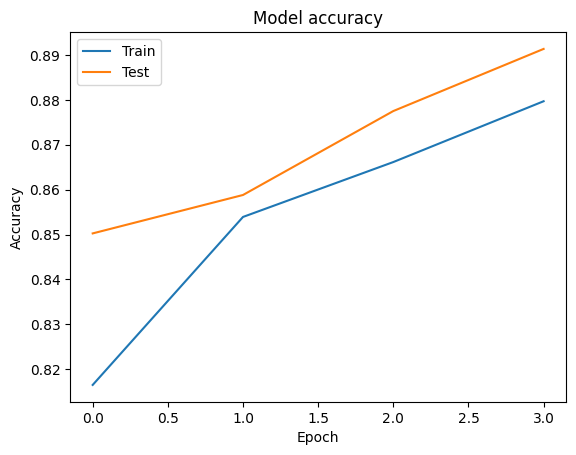

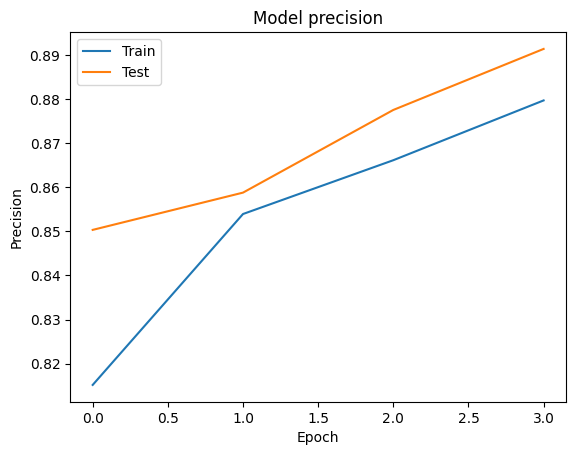

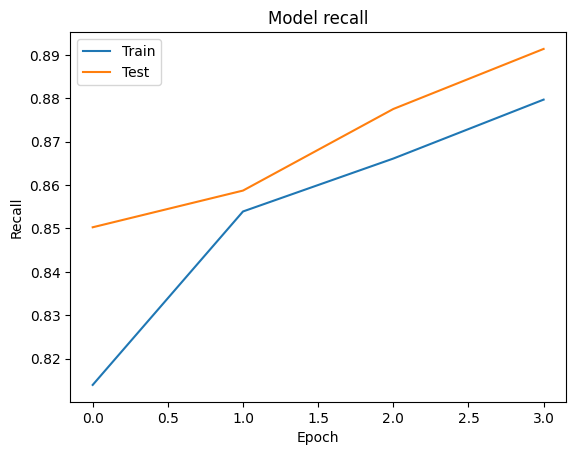

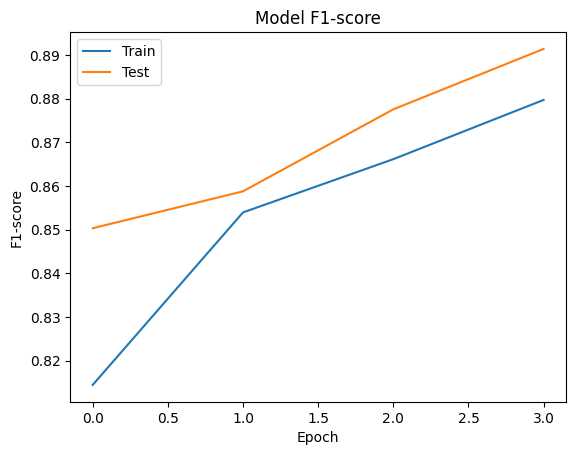

2090/2090 [==============================] - 23s 11ms/step - loss: 0.1978 - accuracy: 0.9087 - precision: 0.9087 - recall: 0.9087 - f1_score: 0.9087 - val_loss: 0.2080 - val_accuracy: 0.9083 - val_precision: 0.9082 - val_recall: 0.9082 - val_f1_score: 0.9082


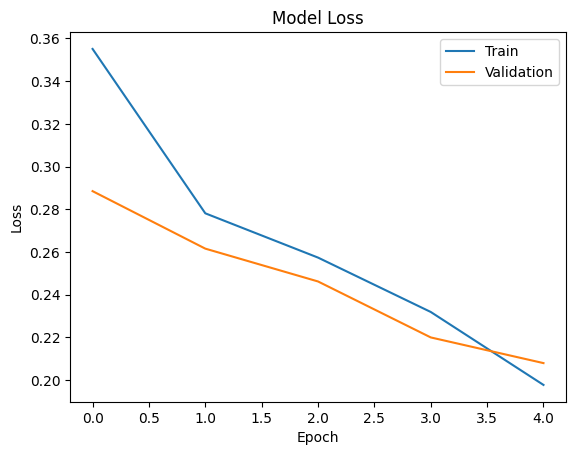

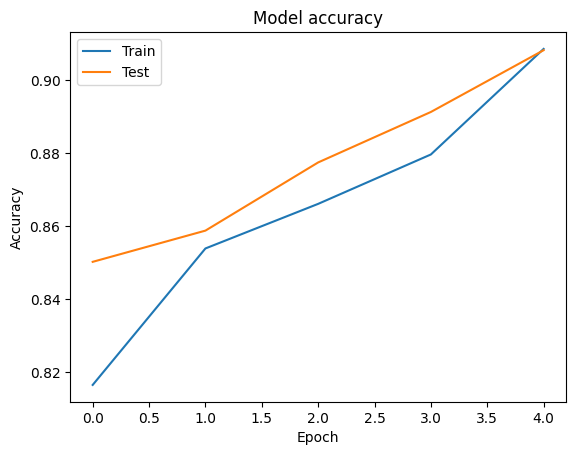

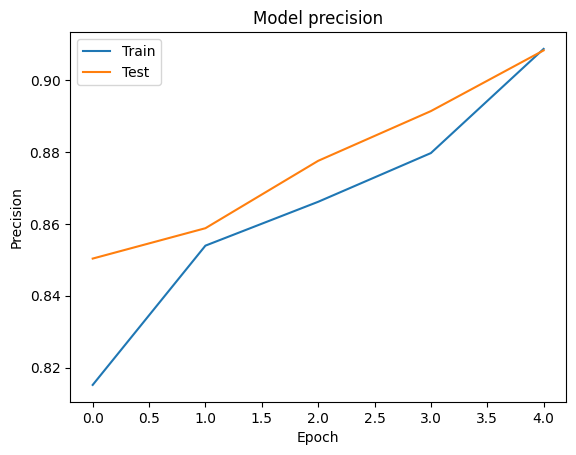

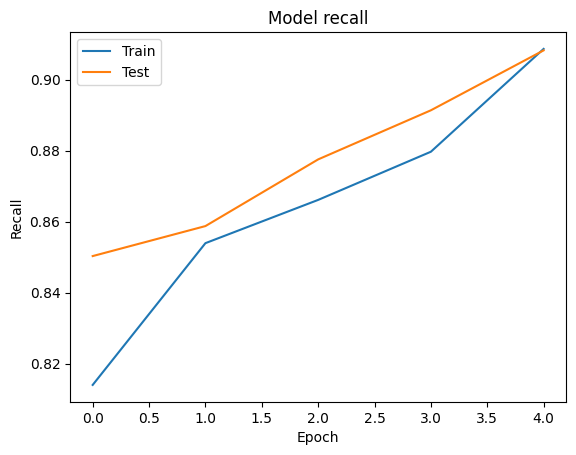

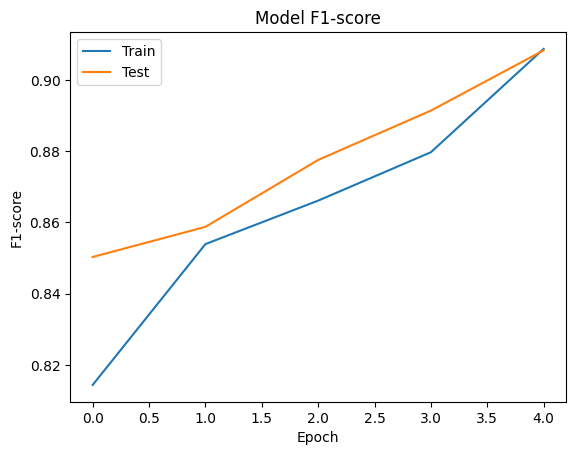

2090/2090 [==============================] - 22s 11ms/step - loss: 0.1553 - accuracy: 0.9350 - precision: 0.9350 - recall: 0.9350 - f1_score: 0.9350 - val_loss: 0.1329 - val_accuracy: 0.9469 - val_precision: 0.9468 - val_recall: 0.9468 - val_f1_score: 0.9468


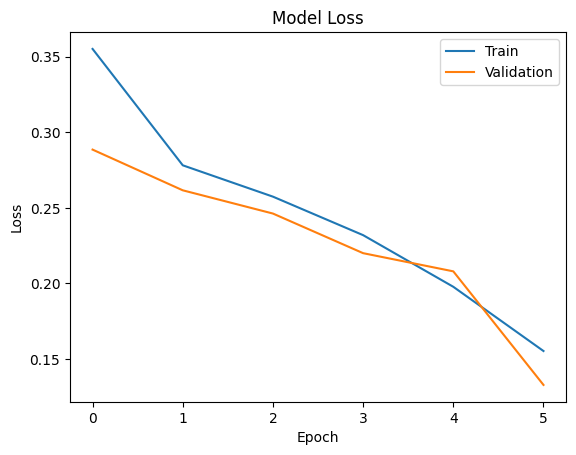

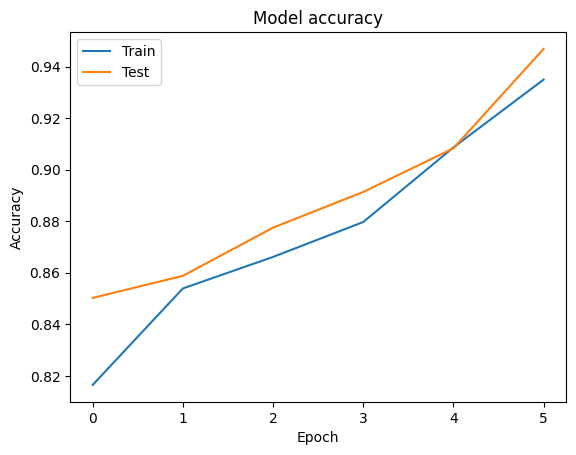

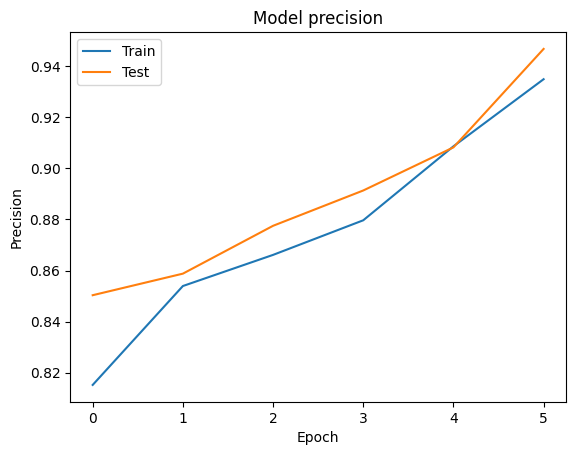

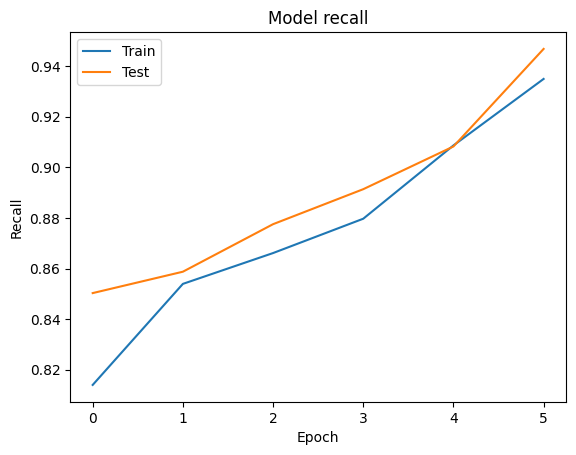

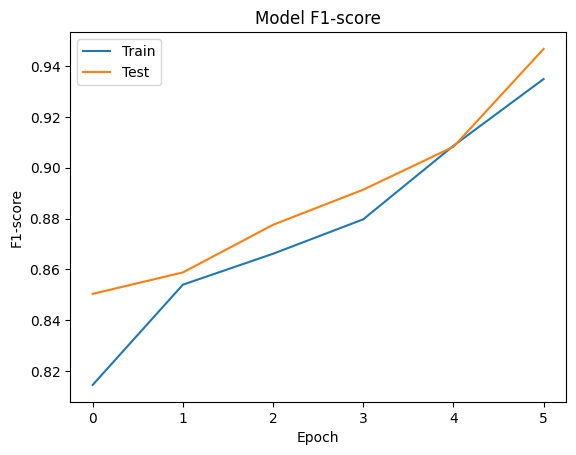

2090/2090 [==============================] - 23s 11ms/step - loss: 0.1360 - accuracy: 0.9450 - precision: 0.9450 - recall: 0.9450 - f1_score: 0.9450 - val_loss: 0.1395 - val_accuracy: 0.9464 - val_precision: 0.9464 - val_recall: 0.9464 - val_f1_score: 0.9464


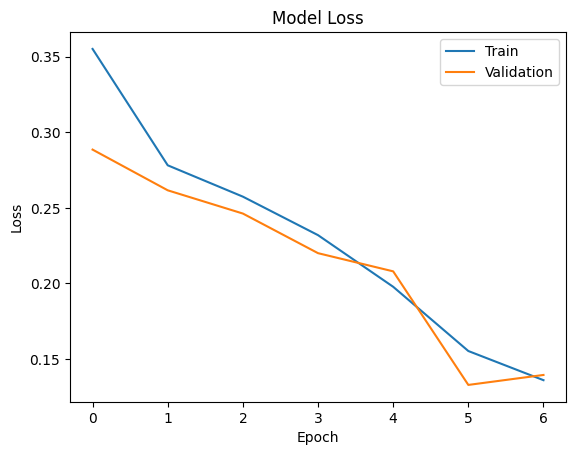

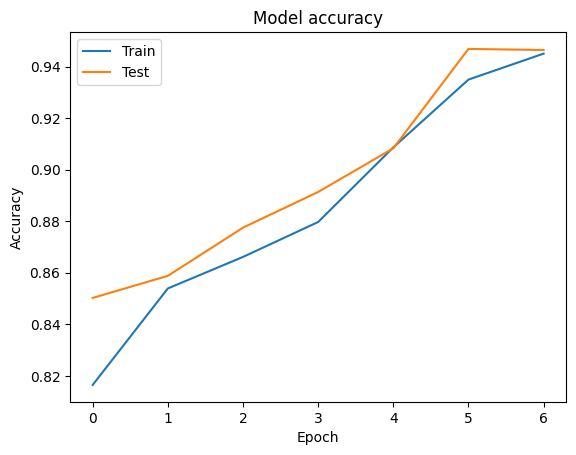

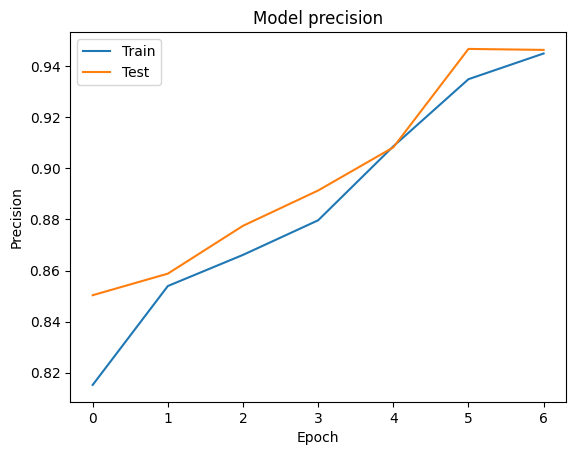

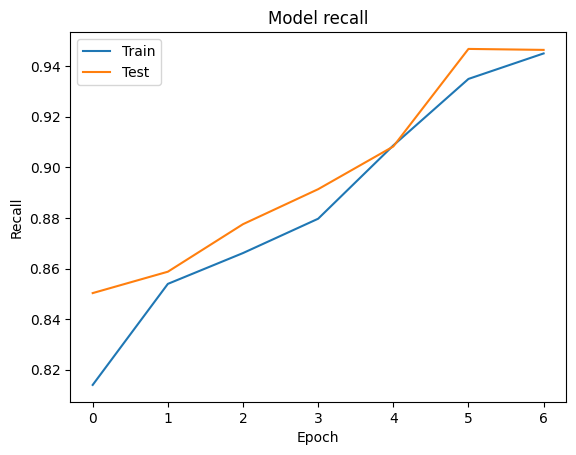

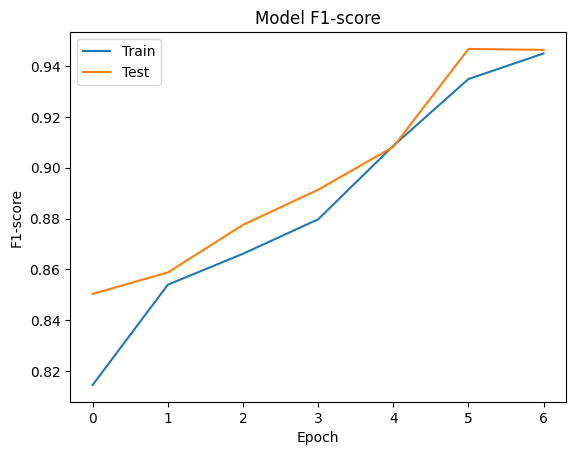

2090/2090 [==============================] - 23s 11ms/step - loss: 0.1288 - accuracy: 0.9486 - precision: 0.9486 - recall: 0.9486 - f1_score: 0.9486 - val_loss: 0.1330 - val_accuracy: 0.9464 - val_precision: 0.9464 - val_recall: 0.9464 - val_f1_score: 0.9464


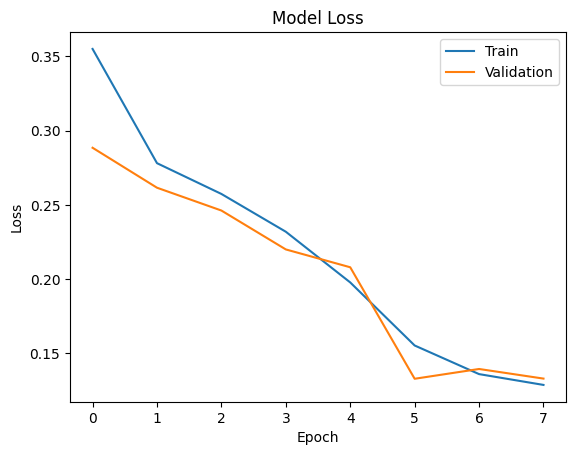

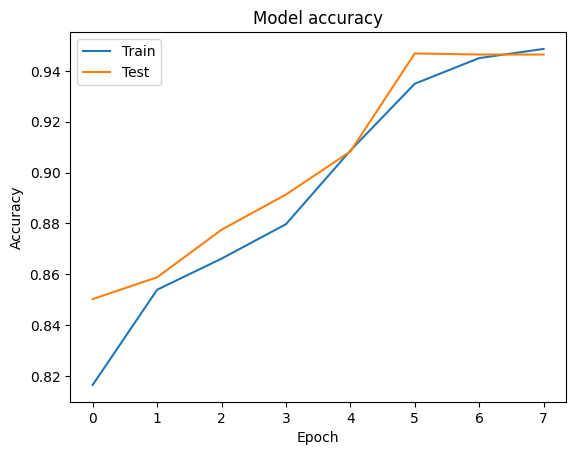

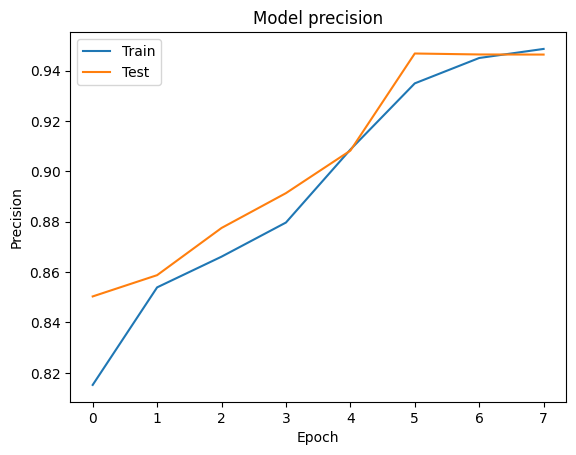

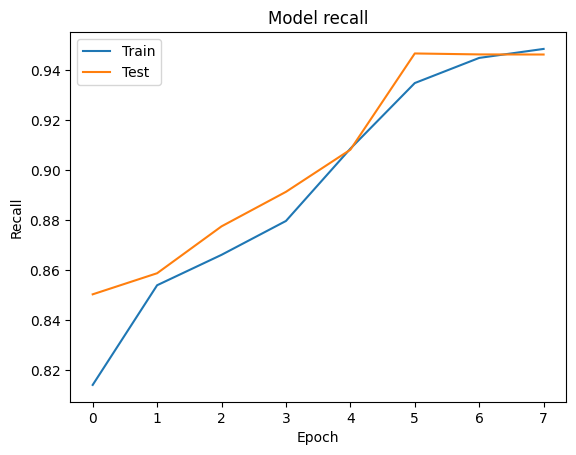

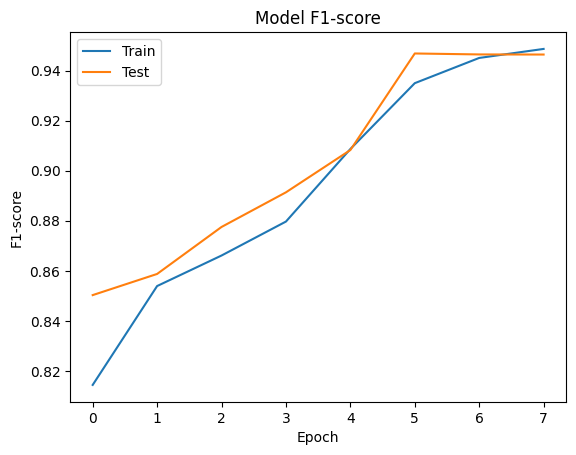

2090/2090 [==============================] - 22s 11ms/step - loss: 0.1238 - accuracy: 0.9505 - precision: 0.9506 - recall: 0.9506 - f1_score: 0.9506 - val_loss: 0.1253 - val_accuracy: 0.9492 - val_precision: 0.9492 - val_recall: 0.9492 - val_f1_score: 0.9492


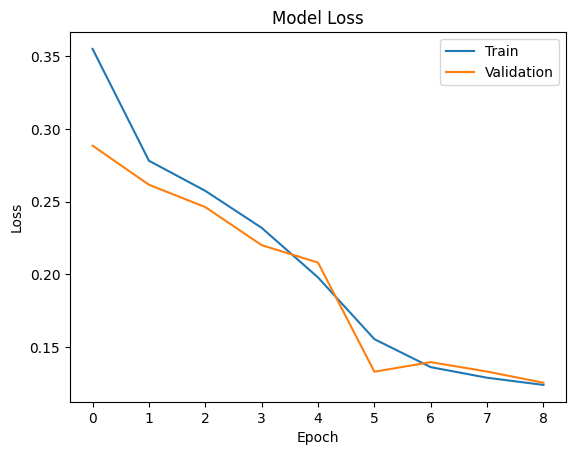

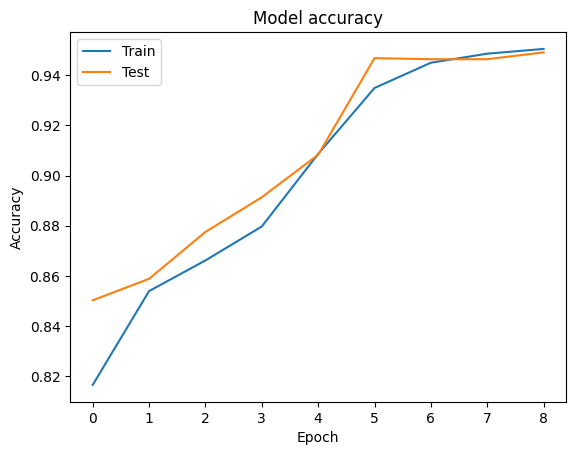

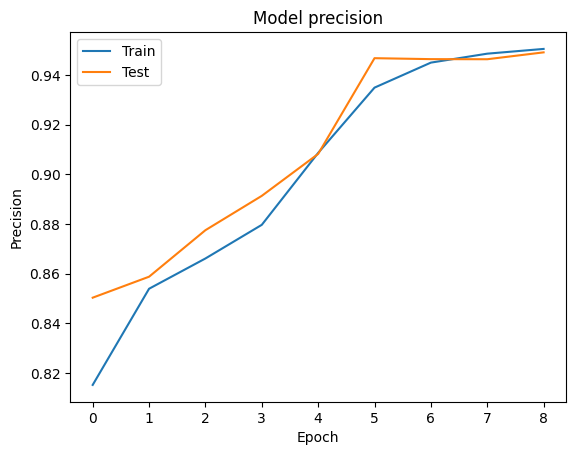

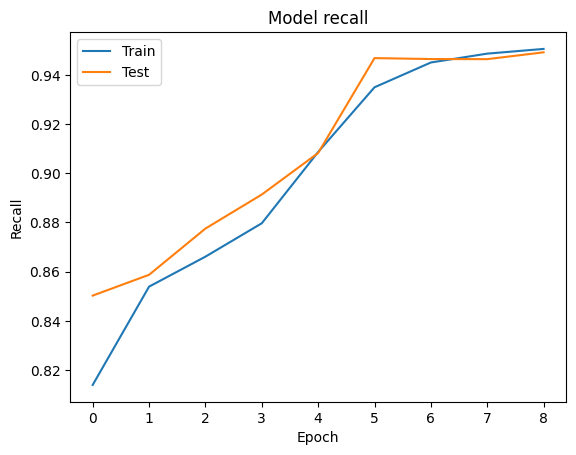

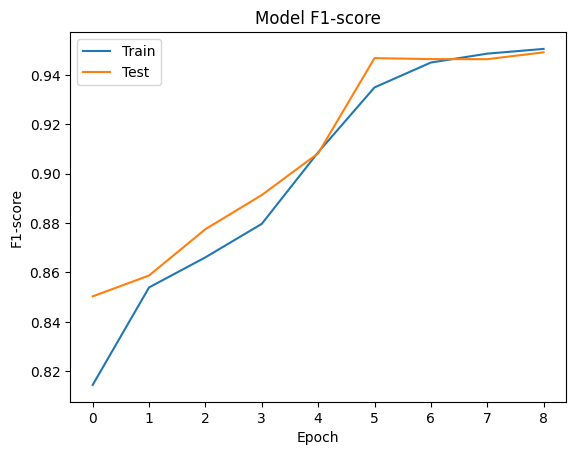

2090/2090 [==============================] - 26s 13ms/step - loss: 0.1193 - accuracy: 0.9524 - precision: 0.9524 - recall: 0.9524 - f1_score: 0.9524 - val_loss: 0.1118 - val_accuracy: 0.9552 - val_precision: 0.9552 - val_recall: 0.9552 - val_f1_score: 0.9552


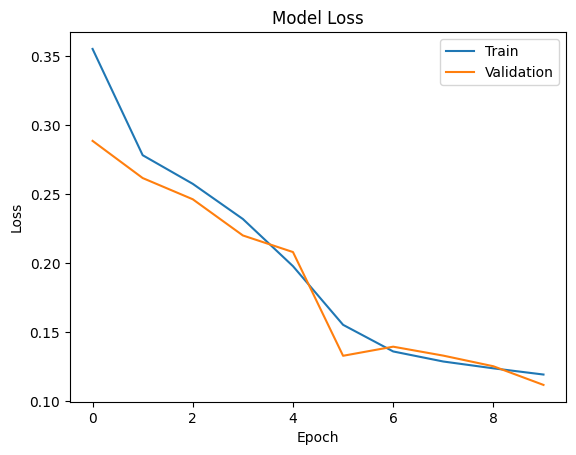

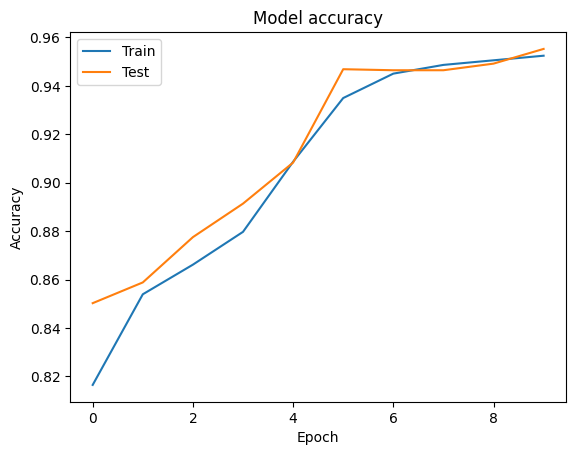

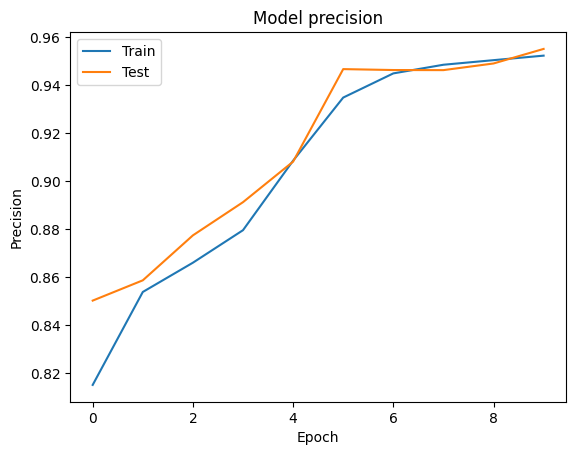

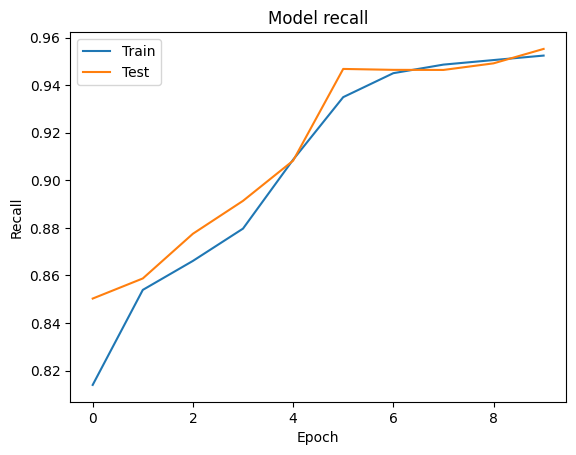

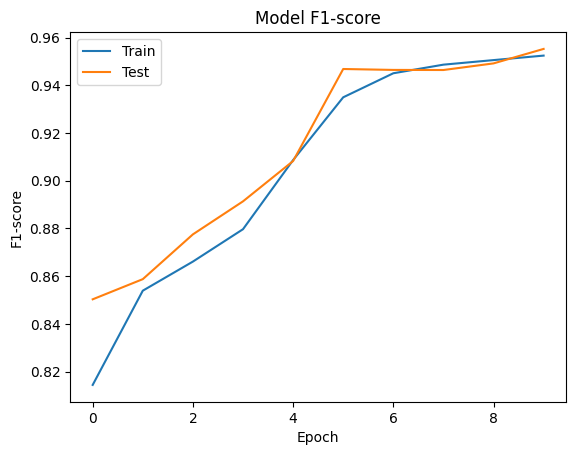

In [16]:

# Define the model
model = keras.models.Sequential([
    keras.layers.Bidirectional(keras.layers.LSTM(128, input_shape=(X_train_extended.shape[1], 1))),
    keras.layers.Dense(10, activation="softmax")
])

# Compile the model
model.compile(loss="categorical_crossentropy",
              optimizer="adam",
              metrics=["accuracy", precision, recall, f1_score])

import pickle

# Initialize lists to store the metrics
train_loss = []
train_acc = []
train_precision = []
train_recall = []
train_f1_score = []

val_loss = []
val_acc = []
val_precision = []
val_recall = []
val_f1_score = []

# Train the model and save it after each epoch
for epoch in range(10):
    history = model.fit(X_train_extended.reshape(X_train_extended.shape[0], X_train_extended.shape[1], 1),
                        y_train_extended,
                        epochs=1,
                        batch_size=32,
                        validation_data=(X_val.reshape(X_val.shape[0], X_val.shape[1], 1), y_val))
    
    # Save the model as an object in the environment
    with open(f"b_model_epoch{epoch+1}.pkl", "wb") as f:
        pickle.dump(model, f)
    
    # Append the metrics to their respective lists
    train_loss.append(history.history['loss'][0])
    train_acc.append(history.history['accuracy'][0])
    train_precision.append(history.history['precision'][0])
    train_recall.append(history.history['recall'][0])
    train_f1_score.append(history.history['f1_score'][0])
    
    val_loss.append(history.history['val_loss'][0])
    val_acc.append(history.history['val_accuracy'][0])
    val_precision.append(history.history['val_precision'][0])
    val_recall.append(history.history['val_recall'][0])
    val_f1_score.append(history.history['val_f1_score'][0])
    
    # Plot the metrics after each epoch
    plt.plot(train_loss)
    plt.plot(val_loss)
    plt.title('Model Loss')
    plt.ylabel('Loss')
    plt.xlabel('Epoch')
    plt.legend(['Train', 'Validation'], loc='upper right')
    plt.show()

    plt.plot(train_acc)
    plt.plot(val_acc)
    plt.title('Model accuracy')
    plt.ylabel('Accuracy')
    plt.xlabel('Epoch')
    plt.legend(['Train', 'Test'], loc='upper left')
    plt.show()

    plt.plot(train_precision)
    plt.plot(val_precision)
    plt.title('Model precision')
    plt.ylabel('Precision')
    plt.xlabel('Epoch')
    plt.legend(['Train', 'Test'], loc='upper left')
    plt.show()

    plt.plot(train_recall)
    plt.plot(val_recall)
    plt.title('Model recall')
    plt.ylabel('Recall')
    plt.xlabel('Epoch')
    plt.legend(['Train', 'Test'], loc='upper left')
    plt.show()

    plt.plot(train_f1_score)
    plt.plot(val_f1_score)
    plt.title('Model F1-score')
    plt.ylabel('F1-score')
    plt.xlabel('Epoch')
    plt.legend(['Train', 'Test'], loc='upper left')
    plt.show()


5480/5480 - 22s - loss: 0.2516 - accuracy: 0.8774 - precision: 0.8775 - recall: 0.8774 - f1_score: 0.8775 - 22s/epoch - 4ms/step
Model 1: Test loss: 0.2516, Test accuracy: 0.8774, Test precision: 0.8775, Test recall: 0.8774, Test F1 score: 0.8775
5480/5480 - 22s - loss: 0.2440 - accuracy: 0.8530 - precision: 0.8531 - recall: 0.8530 - f1_score: 0.8530 - 22s/epoch - 4ms/step
Model 2: Test loss: 0.2440, Test accuracy: 0.8530, Test precision: 0.8531, Test recall: 0.8530, Test F1 score: 0.8530
5480/5480 - 22s - loss: 0.2260 - accuracy: 0.8927 - precision: 0.8927 - recall: 0.8927 - f1_score: 0.8927 - 22s/epoch - 4ms/step
Model 3: Test loss: 0.2260, Test accuracy: 0.8927, Test precision: 0.8927, Test recall: 0.8927, Test F1 score: 0.8927
5480/5480 - 23s - loss: 0.2516 - accuracy: 0.8806 - precision: 0.8806 - recall: 0.8806 - f1_score: 0.8806 - 23s/epoch - 4ms/step
Model 4: Test loss: 0.2516, Test accuracy: 0.8806, Test precision: 0.8806, Test recall: 0.8806, Test F1 score: 0.8806
5480/5480 - 

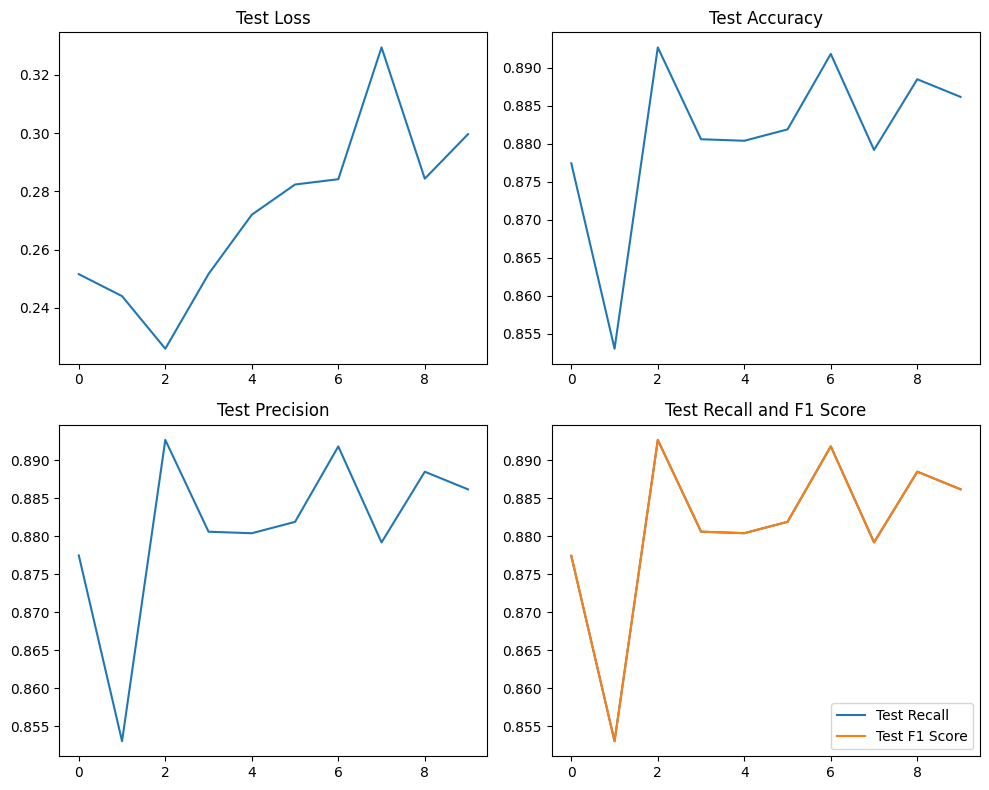

In [17]:
test_losses = []
test_accs = []
test_precisions = []
test_recalls = []
test_f1_scores = []

# Load each saved model and evaluate on the test set
for i in range(1, 11):
    model_path = f"b_model_epoch{i}.pkl"
    with open(model_path, "rb") as f:
        model = pickle.load(f)
    test_loss, test_acc, test_precision, test_recall, test_f1_score = model.evaluate(X_test.reshape(X_test.shape[0], X_test.shape[1], 1), y_test, verbose=2)
    print(f"Model {i}: Test loss: {test_loss:.4f}, Test accuracy: {test_acc:.4f}, Test precision: {test_precision:.4f}, Test recall: {test_recall:.4f}, Test F1 score: {test_f1_score:.4f}")
    
    test_losses.append(test_loss)
    test_accs.append(test_acc)
    test_precisions.append(test_precision)
    test_recalls.append(test_recall)
    test_f1_scores.append(test_f1_score)

# Plot the metrics
fig, axs = plt.subplots(2, 2, figsize=(10, 8))
axs[0, 0].plot(test_losses)
axs[0, 0].set_title('Test Loss')
axs[0, 1].plot(test_accs)
axs[0, 1].set_title('Test Accuracy')
axs[1, 0].plot(test_precisions)
axs[1, 0].set_title('Test Precision')
axs[1, 1].plot(test_recalls, label='Test Recall')
axs[1, 1].plot(test_f1_scores, label='Test F1 Score')
axs[1, 1].set_title('Test Recall and F1 Score')
axs[1, 1].legend()
plt.tight_layout()
plt.show()